In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
import os
import pickle
sys.path.append("../vff")

from run_1d import main 
import torch

import itertools as it
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

Is GPU available? False
Device cpu


# Get training data

## Runing Ising with double space to generate data for different L

We want to create a data set $\mathcal{D}\{x_i, \boldsymbol{y}_i\}$ where $x_i$ are the system sizes $L$ and times $t$ and $\boldsymbol{y}_i$ are the weights of the two layers. We fix the parameters of the Hamiltonian and time.

In [4]:
t_list = [0.1,0.2,0.3,0.4,0.5]

In [8]:
config = {
    # MODEL
    'L': 8,
    'hamiltonian': 'ising',
    't': 0.5,
    # TEBD
    'test_size': 100,  # number of states in test ensemble
    'tebd_test_steps': 20,  # number of steps in TEBD
    'max_bond': None,  # maximum bond dimension in tebd
    'tebd_cutoff': 1e-10,  # maximum bond dimension in tebd
    # 'ctg': True,
    # TRAINING
    'circuit_name': 'brickwall',
    'circuit_translation': True,  # translation invariant circuit
    'num_steps': 1000,  # maximum number of optimization steps
    'num_samples': 8,  # number of training samples
    'training_states': 'product',
    # STRATEGY`
    'training_strategy': 'multiple_times',
    # HOTSTART
    'depth': 2,  # maximum circuit depth
    'times': t_list,  # increase depth per step
    # OPTIMIZATION
    'learning_rate': 0.001,
    'learning_rate_schedule': lambda opt: torch.optim.lr_scheduler.StepLR(opt, step_size=200, gamma=0.5),
    # META
    'TRAIN': True,
    'TEST': True,
    'TEST_UNITARY': False,
    'PLOT': False,
    'SHOW': False,
    'SEED': 0
}

Is GPU available? False
Device cpu


In [10]:
main(config)

Model ising of size 8 at time 0.500

TEBD steps: 10
TEBD max bond dimension: None
TEBD cutoff: 1e-10

(multiple_times) Depth = 2
(multiple_times) Times = [0.1, 0.2, 0.3, 0.4, 0.5]

Circuit: brickwall
Translation: True
Type of training state: product
Number of steps: 1000
Number of samples: 8
Training strategy: multiple_times

Training for t=0.100
Restored train dataset from file
TEBD error: 7.881415431700194e-06
DEPTH = 2
Data for depth 2 exists, loss = 0.00036433096253707387
Test loss for 100 samples = 0.0005815360089830302
Training for t=0.200
Restored train dataset from file
TEBD error: 9.926764821724402e-06
DEPTH = 2
Data for depth 2 exists, loss = 0.0004494440531664923
Test loss for 100 samples = 0.0006804066176094858
Training for t=0.300
Restored train dataset from file
TEBD error: 9.966493965335709e-06
DEPTH = 2
Data for depth 2 exists, loss = 0.0016380684779024879
Test loss for 100 samples = 0.0018835474922809237
Training for t=0.400
Restored train dataset from file
TEBD error:

# Creating dataset

In [318]:
config_path = config.copy()
config_path['GET_PATH'] = True
config_path['PRINT'] = False

L_list = [2**i for i in range(3, 7)]#config['max_factor']+2)]
depth = config['depth']
data_x = []
data_y = []
infidelities = []
for L in L_list:
    for t in t_list:
        config_path['t'] = t
        save_path = main(config_path)
        save_path_L = f"{save_path}/L_{L}/depth_{2}/ckpts/parameters.ckpt"
        fid = np.load(f"{save_path}/L_{L}/depth_{2}/test_loss_100.npy")
        infidelities.append(fid)
        # Input data x is the system size and time
        data_x.append((L, t))
        # Output are flattened parameters
        # Load parameters and flatten them
        parameters = torch.load(save_path_L)
        parameters_flattened = []
        for k in parameters.keys():
            U = parameters[k].reshape(4,4)
            pflat = np.array(parameters[k]).flatten()
            parameters_flattened.append(np.concatenate([pflat.real, pflat.imag]))
        data_y.append(np.stack(parameters_flattened))

## Let's look at the data

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

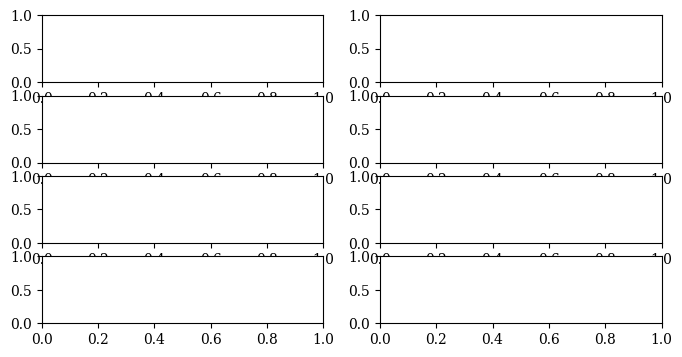

In [321]:
fig, axs = plt.subplots(len(L_list),2)
fig.set_size_inches(8,4)
for x,y in zip(data_x, data_y):
    axs[0].plot(y[0], label=f'L={x[0]}, t={x[1]}')
    axs[0].set_title('Layer 1')
    axs[1].plot(y[1], label=f'L={x[0]}, t={x[1]}')
    axs[1].set_title('Layer 2')
for ax in axs:
    ax.set_xlabel('$i$')
    ax.set_ylabel('$W_i$')
axs[0].legend()
plt.show()

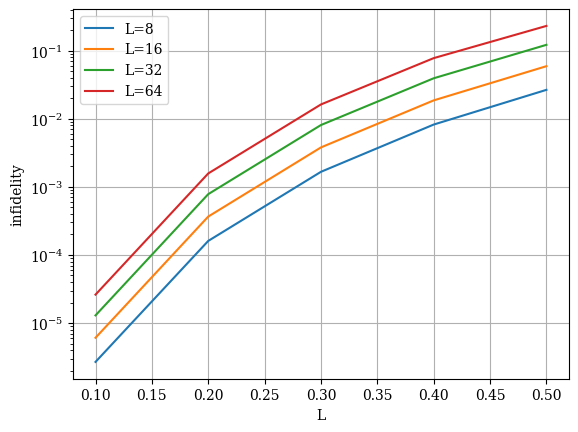

In [320]:
for L in L_list:
    infidelities_t = []
    for t in t_list:
        for i, x in enumerate(data_x):
            if x[0]==L and x[1]==t:
                infidelities_t.append(infidelities[i])        
    plt.plot(t_list, infidelities_t, label=f'L={L}')
plt.xlabel('L')
plt.ylabel('infidelity')
plt.yscale('log')
# plt.ylim(1e-3, 1)
plt.grid()
plt.legend()
plt.savefig("infidelity.png")
plt.show()

Weights seem to converge to brown line and is in domain [-1,1]... Should be easy to learn. Let's split the training data in $L_{train}=4,8,16,32$ and $L_{test}= 64,128,$

In [284]:
from torch.utils.data import Dataset

In [285]:
def train_test_split(x, y):
    """Train data is L<=32 and t<=0.3"""
    x_train, x_test = [], []
    y_train, y_test = [], []
    for x_i, y_i in zip(x,y):
        if x_i[0]<=32 and x_i[1]<=0.3:
            x_train.append(x_i)
            y_train.append(y_i)
        else:
            x_test.append(x_i)
            y_test.append(y_i)
    return x_train, x_test, y_train, y_test
    

In [286]:
data_y = [d.flatten() for d in data_y]
print(data_x)
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(data_x, data_y)
print(f"Train inputs: L = {data_x_train}")
print(f"Test inputs: L = {data_x_test}")
output_size = data_y_train[0].shape[0]
print(f"Output_size: {output_size}")
train_set_size = len(data_y_train)
test_set_size = len(data_y_test)
print(f"Data set size (train): {data_set_size}")
print(f"Data set size (test): {test_set_size}")
print(data_y_train[0].shape)

[(8, 0.1), (8, 0.2), (8, 0.3), (8, 0.4), (8, 0.5)]
Train inputs: L = [(8, 0.1), (8, 0.2), (8, 0.3)]
Test inputs: L = [(8, 0.4), (8, 0.5)]
Output_size: 64
Data set size (train): 9
Data set size (test): 2
(64,)


# Creating a simple Neural Network

In [287]:
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset

import tqdm

In [288]:
class Net(nn.Module):
    def __init__(self, output_size):
      super(Net, self).__init__()
      self.dense_1 = nn.Linear(2, 1000)
      self.dense_2 = nn.Linear(1000, 100)
      self.dense_3 = nn.Linear(100, 100)
      self.dense_out = nn.Linear(100, output_size)
    # x represents our data
    def forward(self, x):
        # Pass data through conv1
      x = self.dense_1(x)
      x = F.sigmoid(x)

      x = self.dense_2(x)
      x = F.sigmoid(x)

      x = self.dense_3(x)
      x = F.sigmoid(x)
        
      x = self.dense_out(x)
      output = F.tanh(x)

      return output

In [289]:
model = Net(output_size)
test_output = model(torch.tensor(data_x_train, dtype=torch.float32)[:,None])
print(f"Output: {test_output[0]}")

Output: tensor([[-1.7869e-01,  1.4950e-01, -4.6150e-01,  6.9691e-02,  3.1421e-01,
          2.3157e-01, -5.2988e-02, -4.9108e-02, -7.5172e-02, -7.7497e-02,
          1.1640e-01,  4.5041e-01, -2.5067e-02, -4.3381e-01,  1.2080e-01,
         -4.5704e-02,  2.6044e-01,  2.2874e-01,  4.7961e-01,  2.3936e-01,
         -2.5891e-01, -4.5583e-01, -4.1384e-02,  4.9525e-04,  1.3077e-01,
         -3.3707e-01, -2.3195e-01,  1.7227e-02, -5.6011e-02, -3.7289e-01,
          5.0130e-01, -2.4572e-01,  2.1740e-01, -1.1640e-01,  3.2662e-02,
         -1.6647e-01,  3.2969e-01, -4.3862e-01,  2.4497e-01, -2.9198e-01,
          1.6225e-01,  5.8693e-02, -8.6380e-02,  3.5043e-01, -3.1496e-01,
         -1.1946e-01,  3.5361e-01,  5.6805e-01, -2.7032e-01,  3.9957e-01,
         -3.4655e-01,  5.4334e-01,  9.0091e-02, -1.2408e-01,  2.6270e-01,
         -1.4896e-01,  5.0728e-01, -2.0076e-01,  3.8468e-01, -1.7610e-01,
         -3.6179e-01,  3.6381e-01,  3.4733e-01,  1.9245e-01]],
       grad_fn=<SelectBackward0>)


## Creating a Dataset instance in Torch

In [244]:
class MPSWeightDataset(Dataset):
    def __init__(self, x, y):
        self.data = torch.tensor(x, dtype=torch.float32)[:,None]
        self.labels = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

We're performing online learning, so there are no separate batches. For larger data sets, we may want to set the batch size to 64 to train the model in steps.

In [263]:
train_dataloader = DataLoader(MPSWeightDataset(data_x_train, data_y_train), batch_size=3)
test_dataloader = DataLoader(MPSWeightDataset(data_x_test, data_y_test), batch_size=test_set_size)

## Create training and test loop

In [270]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    loss_tot = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_tot += loss.item()
    return loss_tot


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    return  test_loss / size


An epoch in Machine learning is one step where the model has seen all the data. We use an MSE combined with Adam to find the correct weights.

In [290]:
epochs = 3000
learning_rate = 1e-3
losses = []

loss_fn = nn.MSELoss()
model = Net(output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_loss = test_loop(test_dataloader, model, loss_fn)
print(f"Test loss before train: {test_loss}!")
pbar = tqdm.tqdm(range(epochs), bar_format="\t{l_bar}{bar:25}{r_bar}{bar:-25b}")
for step in pbar:
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    pbar.set_description(f"Train loss={loss}")
    losses.append(loss)
test_loss = test_loop(test_dataloader, model, loss_fn)
print(f"Test loss after train: {test_loss}!")

Test loss before train: 0.07730714976787567!


	Train loss=0.002976449439302087: 100%|█████████████████████████| 3000/3000 [00:04<00:00, 692.47it/s]                                                                 


Test loss after train: 0.00768377585336566!


0.00768377585336566


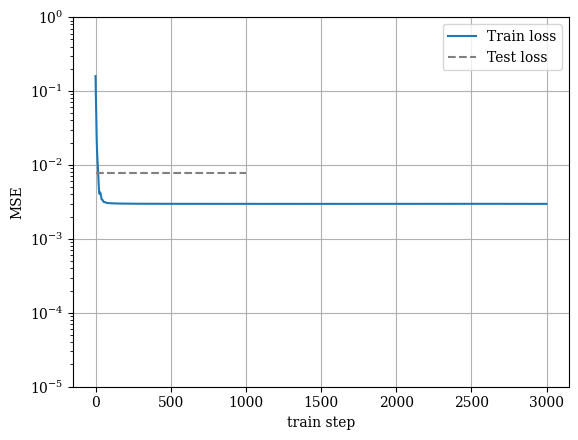

In [291]:
plt.plot(np.abs(losses), label='Train loss')
print(test_loss)
plt.hlines(test_loss, 0, 1000, label='Test loss', color='gray',linestyle='dashed')
plt.xlabel('train step')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.ylim([1e-5, 1])
plt.grid()
plt.savefig("loss.png")

We see that we can quickly train the model to predict the correct weights for $L_{train}=4,8,16,32$. The test loss indicates that we can then produce the weights for $L_{test}= 64,128,$ with very high accuracy, even though they were never seen in the training data. The test loss is higher because we overfit on the test data.

# Predicting new weights for L=256

In [203]:
from tn.mps_circuit import TNModel, qmps_brick, qmps_brick_quasi_1d, create_targets, load_gates
from tn.data_states import random_product_state, \
    random_mps_state, get_make_data_set_fn, random_U1_state
from tn.tebd import ising_hamiltonian_quimb, \
    longitudinal_ising_hamiltonian_quimb, \
    heisenberg_hamiltonian_quimb, \
    mbl_hamiltonian_quimb
from tn.trotter import trotter_evolution_optimized_nn_ising_tn

We can now use the model to predict weights for other system sizes:

In [204]:
new_L = 32
new_t = 0.3
new_L_weights= model(torch.tensor([new_L, new_t], dtype=torch.float32)[None,:])
new_L_weights_split = np.split(new_L_weights.detach().numpy().flatten(), config['depth']*2)
predicted_parameters = []
for i in range(0, config['depth']*2,2):
    predicted_parameters.append(torch.tensor(new_L_weights_split[i].reshape([2]*4)+1j*new_L_weights_split[i+1].reshape([2]*4)))

In [205]:
SEED = config['SEED']
hamiltonian = config['hamiltonian']
t = new_t
depth = config['depth']
num_samples = 20
circuit_translation =  config['circuit_translation']

g = config.get('g', 1.0)
tebd_cutoff = config.get('tebd_cutoff', -1)  # What is the SVD cutoff for TEBD
tebd_max_bond = config.get('max_bond', 20)  # What is the bond dimension cutoff for TEBD
tebd_opts = {'cutoff': tebd_cutoff, 'max_bond': tebd_max_bond}

tebd_granularity =  int(np.round(t / 0.05))
H = lambda x: ising_hamiltonian_quimb(x, 1.0, g)
get_training_state = lambda x, s: random_product_state(x, s)

make_data_set = get_make_data_set_fn(hamiltonian, H(new_L), tebd_granularity, tebd_opts, False)
psi0_list_train, psit_list_train, tebd_errors = make_data_set(lambda x: get_training_state(new_L, x),
                                                              t,
                                                              num_samples, SEED)
psi_pqc = qmps_brick(new_L, in_depth=depth, rand=False, val_iden=0.01)
psi, psi_tars = create_targets(new_L, psi_pqc, psi0_list_train, psit_list_train, device='cpu')
mps_model = TNModel(psi, psi_tars, translation=circuit_translation)

In [206]:
print("Inidelity before:", mps_model())
par_names = [f"torch_params.{i}" for i in range(config['depth'])]
param_dict = dict(zip(par_names, predicted_parameters))
mps_model.load_state_dict(param_dict, strict=True)
mps_model.eval()
predicted_infidelity = mps_model()
print("Infidelity with predicted weights:", mps_model())

Inidelity before: tensor(0.9873, dtype=torch.float64, grad_fn=<RsubBackward1>)
Infidelity with predicted weights: tensor(0.3205, dtype=torch.float64, grad_fn=<RsubBackward1>)


We get a reasonable infidelity for 

[(8, 0.1), (8, 0.2), (8, 0.3), (8, 0.4), (8, 0.5)]
[(16, 0.1), (16, 0.2), (16, 0.3), (16, 0.4), (16, 0.5)]
[(32, 0.1), (32, 0.2), (32, 0.3), (32, 0.4), (32, 0.5)]
[(64, 0.1), (64, 0.2), (64, 0.3), (64, 0.4), (64, 0.5)]
[(128, 0.1), (128, 0.2), (128, 0.3), (128, 0.4), (128, 0.5)]


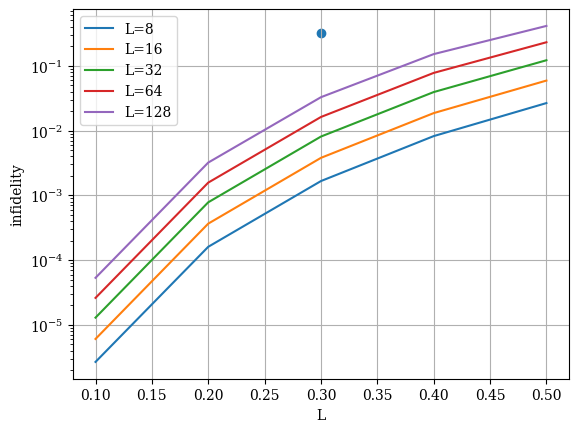

In [207]:
for i in range(5):
    plt.plot(t_list, infidelities[5*i:5*i+5], label=f'L={L_list[i]}')
    print(data_x[5*i:5*i+5])
plt.scatter(t, predicted_infidelity.detach().numpy())
plt.xlabel('L')
plt.ylabel('infidelity')
plt.yscale('log')
# plt.ylim(1e-3, 1)
plt.grid()
plt.legend()
plt.savefig("infidelity.png")
plt.show()

Seems like a reasonable fidelity!